## 2. Preprocessing

All data is preprocessed according to the following steps.
1. Data is split in a training set of 80% of the data and a test set of 20% of the data.
2. Missing feature data is imputed using the mean. Missing target data is inferred from other available metadata.
3. Outliers are removed, data is normalized and centered. Target Y1 is binned per 10 listenings and target Y2 is binned per year.

Next to feature set f1, which contains all features, two more feature sets are created with PCA dimensionality reduction. For feature set f2 PCA is applied per column name group, and for feature set f3 PCA is applied on the total of features.

### Setup

In [77]:
from datetime import datetime

import pandas as pd
import numpy as np

from scipy import stats 

from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [112]:
df = pd.read_csv('data/split/train.csv', parse_dates=['release'])

# m1 = popularity
df_m1 = df.copy().drop(columns=['release'])

# m2 = release
df_m2 = df.copy().drop(columns=['popularity'])

### 2.1 Missing data

#### m1

In [81]:
n_orig = df_m1.shape[0]

# Drop na values
n_na = df_m1['popularity'].isna().sum()
df_m1 = df_m1.dropna(subset=['popularity'])

# Drop zero values
n_zero =df_m1.loc[df_m1['popularity']==0].shape[0]
df_m1 = df_m1.loc[df['popularity']>0]

print(f'm1: Dropped {n_na} na entries and {n_zero} zero entries of {n_orig}, {df_m1.shape[0]} entries left.')


m1: Dropped 0 na entries and 1 zero entries of 85259, 85258 entries left.


#### m2

In [113]:
n_orig = df_m2.shape[0]

# Drop na values
n_na = df_m2['release'].isna().sum()
df_m2 = df_m2.dropna(subset=['release'])

print(f'm2: Dropped {n_na} na of {n_orig}, {df_m2.shape[0]} entries left.')

m2: Dropped 28915 na of 85259, 56344 entries left.


### 2.2 Target transformation

#### y1


In [114]:
y1 = df_m1['popularity']

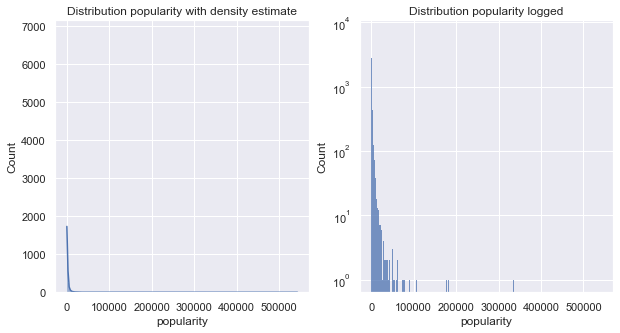

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(x=y1, kde=True, ax=axs[0])
ax1.set(title="Distribution popularity with density estimate")

ax2 = sns.histplot(x=y1, log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution popularity logged")

fig;

In [57]:
y1 = stats.boxcox(y1)[0]

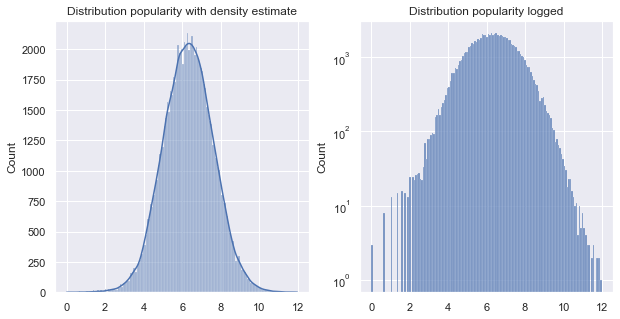

In [49]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(x=y1, kde=True, ax=axs[0])
ax1.set(title="Distribution popularity with density estimate")

ax2 = sns.histplot(x=y1, log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution popularity logged")

fig;

In [58]:
np.savetxt('featsets/y1.csv', y1, delimiter=",")

#### y2

In [115]:
y2 = df_m2['release']
y2 = y2.dt.year.astype(int)

In [118]:
print(y2.value_counts(sort=False).sort_index())

1902       1
1905       1
1907       1
1909       1
1911       2
1912       1
1913       1
1916       1
1930       1
1965       2
1967       2
1968      12
1969       1
1971       7
1973       2
1974       9
1976      12
1978       4
1979       8
1980      11
1981      20
1982      54
1984      14
1985      39
1986      17
1987      23
1988      28
1989       9
1990      19
1991      16
1992      17
1993     111
1994      29
1995     120
1996     142
1997     138
1998     228
1999     323
2000     193
2001     302
2002     379
2003     672
2004    1094
2005    1279
2006    1349
2007    1973
2008    3251
2009    4970
2010    5394
2011    5967
2012    6132
2013    6348
2014    5083
2015    5073
2016    4263
2017    1193
2021       2
Name: release, dtype: int64


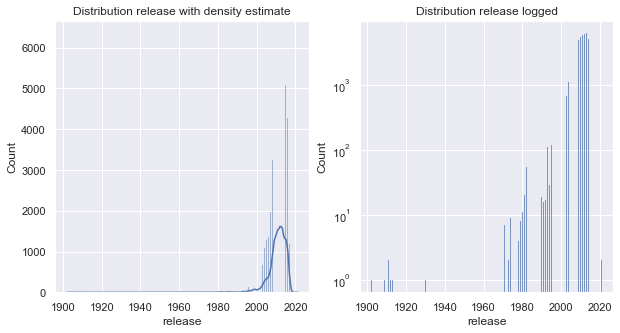

In [119]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(x=y2, kde=True, ax=axs[0])
ax1.set(title="Distribution release with density estimate")

ax2 = sns.histplot(x=y2, log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution release logged")

fig;

In [103]:
y2 = stats.boxcox(y2)[0]

/Users/juliet/Documents/UGENT/2021-2022/big_data/practicals/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/juliet/Documents/UGENT/2021-2022/big_data/practicals/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/juliet/Documents/UGENT/2021-2022/big_data/practicals/venv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


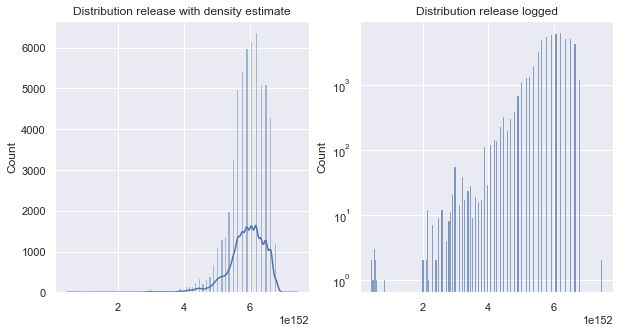

In [105]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(data=y2, kde=True, ax=axs[0])
ax1.set(title="Distribution release with density estimate")

ax2 = sns.histplot(data=y2, log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution release logged")

fig;

In [106]:
np.savetxt('featsets/y2.csv', y2, delimiter=",")

### 2.3 Featsets
Different steps and kinds of preprocessing are combined to produce featuresets.
https://towardsdatascience.com/feature-selection-and-dimensionality-reduction-f488d1a035de

In [32]:
class Featset:
    def __init__(self, X, name):
        self.X = X
        self.name = name

        self.timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        self.outlier_removal = 'None'
        self.scaling_ft = 'None'
        self.dimension_reduction = 'None'

    def remove_stde(self):
        pass

    def remove_lof(self):
        clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
        y_pred = clf.fit_predict(self.X)
        X_scores = clf.negative_outlier_factor_
        pass

    def remove(self, type):
        if type == "stde":
            self.stde()
            self.outlier = 'stde'
        elif type == "lof":
            self.lof()
            self.outlier = 'lof'
        else:
            print("Not available")
            pass

    def scaling(self, type):
        pass
    
    def reduce_pca(self, type):
        pass

    def reduce(self, type):
        if type == "pca":
            self.reduce_pca()
            self.outlier = 'stde'
        else:
            print("Not available")
            pass

    def save(self):
        np.savetxt(f'featsets/{self.name}.csv', self.X, delimiter=",")

#### X1

In [67]:
X1 = df_m1.drop(columns=['popularity'])
X1.to_csv('featsets/X1.csv', sep=",", index=False, header=False)

#### X2

In [107]:
X2 = df_m2.drop(columns=['release'])
X2.to_csv('featsets/X2.csv', sep=",", index=False, header=False)